In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [ ]:
!pip install git+https://github.com/alessiogmonti/visualkeras 
import visualkeras

  Cloning https://github.com/alessiogmonti/visualkeras to /tmp/pip-req-build-ljj3eo3_
  Running command git clone -q https://github.com/alessiogmonti/visualkeras /tmp/pip-req-build-ljj3eo3_
     |████████████████████████████████| 795 kB 6.3 MB/s 
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=12988 sha256=bc94527129ef052fc3580f283915d9c0cc2a5b4eab358b9be6baf3efca507aef
  Stored in directory: /tmp/pip-ephem-wheel-cache-aruyk6s_/wheels/8c/98/da/cd792cfaef8538e6921280cf1070358a4c09e7c50569f5bc69
Successfully built visualkeras


In [ ]:
!pip install --upgrade tensorflow

In [ ]:
%load_ext tensorboard

In [ ]:
import tensorflow as tf

In [ ]:
df = {}
df['test']= pd.read_csv('test.csv')
df['train'] = pd.read_csv('train.csv')

In [ ]:
def getCatVals(dataframe):
  cats = dataframe.select_dtypes(exclude=['int64','float64'])
  return cats

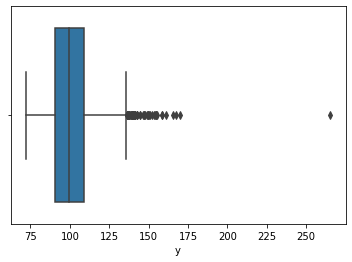

In [ ]:
sns.boxplot(x = df['train']['y'])

In [ ]:
df['train'] = df['train'].drop(df['train'].loc[df['train']['y'] > 150].index)

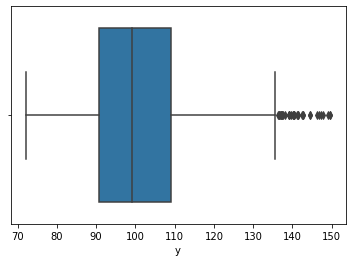

In [ ]:
sns.boxplot(x = df['train']['y'])

In [ ]:
def elbow(df, maxrange=10):
  clusters=range(1,maxrange)
  meandist=[]

  data = df.to_numpy().reshape(-1,1)

  for k in clusters:
      model=KMeans(n_clusters=k)
      model.fit(data)
      clusassign=model.predict(data)
      meandist.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1))
      / data.shape[0])

  plt.plot(clusters, meandist)
  plt.xlabel('Number of clusters')
  plt.ylabel('Average distance')
  plt.title('Selecting k with the Elbow Method') 
  return data

In [ ]:
def getClusters(dataset, nclus):

  k = KMeans(n_clusters=nclus, random_state=42)
  kfit = k.fit(dataset)
  kpred = kfit.predict(dataset)
  return kpred

In [ ]:
def clusterDF(pred, dataframe):
  dataframe['kpred'] = pd.Series(pred, index=dataframe.index)
  return dataframe

In [ ]:
def plotCluster(dataframe, x='y', y='ID'):
  plt.figure(figsize=(10,10))
  sns.scatterplot(data=dataframe,
                  x = x,
                  y = y,
                  hue= 'kpred', palette='tab10')
  plt.title('Y Clusters', fontsize=24)

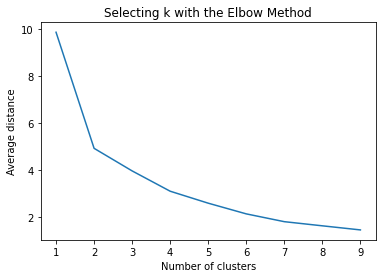

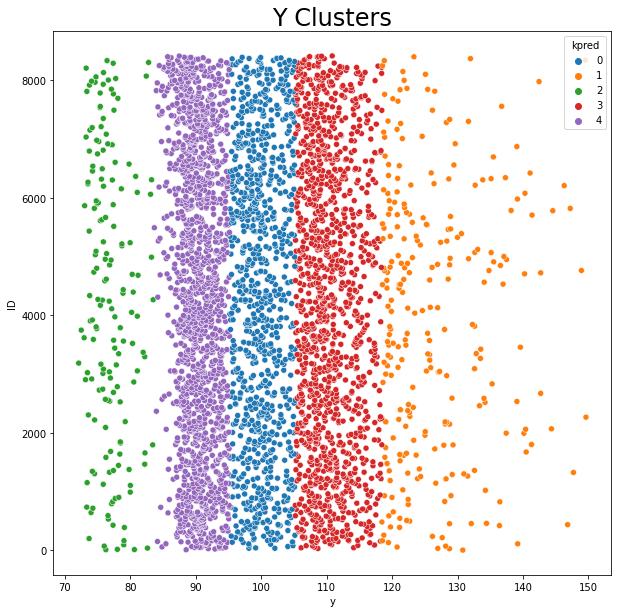

In [ ]:
plotCluster(clusterDF(getClusters(elbow(df['train']['y']), 5),df['train']))

In [ ]:
cat_data = getCatVals(df['train'].drop(['kpred'],axis=1))

In [ ]:
cat_data.head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n


In [ ]:
def catEncode(dataframe):
  for x in dataframe:
    encoder = preprocessing.LabelEncoder()
    dataframe[x] = encoder.fit_transform(dataframe[x])
  return dataframe

In [ ]:
encoded = catEncode(cat_data)

In [ ]:
for x in encoded.columns:
  print(encoded[x].nunique())

47
27
44
7
4
29
12
25


In [ ]:
encoded.head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,32,23,17,0,3,24,9,14
1,32,21,19,4,3,28,11,14
2,20,24,34,2,3,27,9,23
3,20,21,34,5,3,27,11,4
4,20,23,34,5,3,12,3,13


In [ ]:
# card1 = list()
# for x in onehot:
#   if onehot[x].nunique() ==1 :
#     card1.append(x)

# card1.append('ID')
# onehot = df['train'].select_dtypes(include='int64').drop(card1,axis=1)

In [ ]:
# tosplit = pd.merge(encoded,onehot, right_index=True,left_index=True)

In [ ]:
models = []
inputs = []

for cat in encoded.columns:
  vocab_size = encoded[cat].nunique()
    
  input = tf.keras.layers.Input(shape=(1,),name='input_' + '_'.join(cat.split(' ')))
  inputs.append(input)

  embed = tf.keras.layers.Embedding(vocab_size, 30,trainable=True,embeddings_initializer=tf.initializers.random_normal)(input)
  embed_reshaped = tf.keras.layers.Reshape(target_shape=(30,))(embed)
  models.append(embed_reshaped)

In [ ]:
# for x in onehot:
#   num_size = onehot[x].nunique()
#   num_input = tf.keras.layers.Input(shape=(1,),name='input_'+'_'.join(x.split(' ')))
#   inputs.append(num_input)

#   num_embed = tf.keras.layers.Embedding(num_size, 30, trainable=True, embeddings_initializer=tf.initializers.random_normal)(num_input)
#   num_embed_reshaped = tf.keras.layers.Reshape(target_shape=(30,))(num_embed)
#   models.append(num_embed_reshaped)

In [ ]:
merged_models= tf.keras.layers.concatenate(models)

In [ ]:
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=100, restore_best_weights=True)
mchecks = tf.keras.callbacks.ModelCheckpoint(filepath='checkpointFolder',
                                               save_weights_only=True,
                                              monitor='val_mean_absolute_error',
                                              mode='max',
                                              save_best_only=True)

pre_preds = tf.keras.layers.Dense(750,kernel_regularizer = 
                                  tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
                                  )(merged_models)#4000
pre_preds = tf.keras.layers.BatchNormalization()(pre_preds)
pre_preds = tf.keras.layers.Dropout(0.87,seed=1997)(pre_preds)
pre_preds = tf.keras.layers.Activation('relu')(pre_preds)

pre_preds = tf.keras.layers.Dense(550,kernel_regularizer = 
                                  tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
                                  )(merged_models)#4000
pre_preds = tf.keras.layers.BatchNormalization()(pre_preds)
pre_preds = tf.keras.layers.Dropout(0.47,seed=1997)(pre_preds)
pre_preds = tf.keras.layers.Activation('relu')(pre_preds)

pred = tf.keras.layers.Dense(1,activation='relu')(pre_preds)
model_full = tf.keras.models.Model(inputs= inputs, outputs =pred)
model_full.compile(loss='mean_squared_error', metrics=['mean_absolute_error'], 
                   optimizer=tf.keras.optimizers.Adam(
                    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
                    name='Adam'))

In [ ]:
model_full.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_X0 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_X1 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_X2 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_X3 (InputLayer)          [(None, 1)]          0           []                               
                                                                                              

In [ ]:
#visualkeras.graph_view(model_full)  

In [ ]:
#visualkeras.layered_view(model_full, legend=True)

In [ ]:
nxtrain, nxval, nytrain, nyval = train_test_split(encoded,df['train']['y'], test_size=0.2, random_state=None)

In [ ]:
train_input= {
    "input_X0":nxtrain["X0"],
    "input_X1":nxtrain["X1"],
    "input_X2":nxtrain["X2"],
    "input_X3":nxtrain["X3"],
    "input_X4":nxtrain["X4"],
    "input_X5":nxtrain["X5"],
    "input_X6":nxtrain["X6"],
    "input_X8":nxtrain["X8"]
}

# for x in onehot.columns:
  # train_input["input_"+x] = nxtrain[x]

In [ ]:
test_input={
    "input_X0":nxval["X0"],
    "input_X1":nxval["X1"],
    "input_X2":nxval["X2"],
    "input_X3":nxval["X3"],
    "input_X4":nxval["X4"],
    "input_X5":nxval["X5"],
    "input_X6":nxval["X6"],
    "input_X8":nxval["X8"]
}

# for x in onehot.columns:
  # test_input["input_"+x] = nxval[x]

In [ ]:
preds = model_full.fit(train_input,nytrain,epochs=1000,batch_size=22, 
                       verbose = True, callbacks=[estopping, mchecks], 
                       validation_data=(test_input,nyval))

In [ ]:
model_full.evaluate(test_input,nyval,batch_size=22)

39/39 [==============================] - 0s 3ms/step - loss: 71.3984 - mean_absolute_error: 5.2541


[71.39838409423828, 5.2540788650512695]

In [ ]:
#model_full.load_weights('checkpointFolder')
#model_full.evaluate(test_input,nyval,batch_size=22)

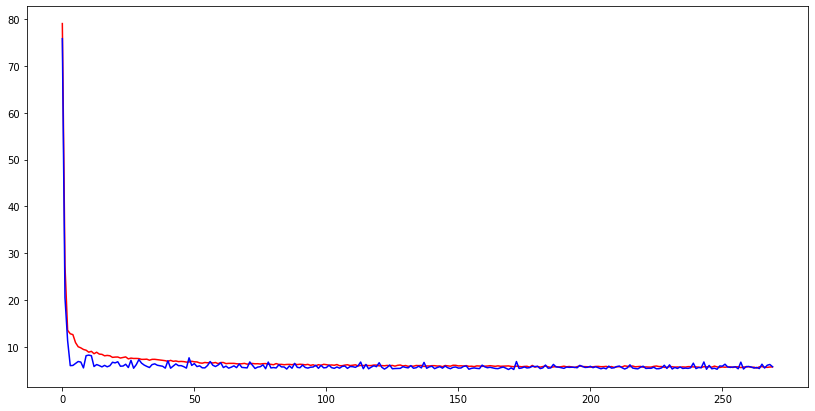

In [ ]:
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(preds.history['mean_absolute_error'],color='red')
plt.plot(preds.history['val_mean_absolute_error'], color='blue')
plt.show()

In [ ]:
embeddings = ['embedding', 'embedding_1','embedding_2','embedding_3','embedding_4',
              'embedding_5','embedding_6','embedding_7']

In [ ]:
weights = {}
for index, x in enumerate(encoded.columns):
  weights[x] = {}
  for id, val in enumerate(encoded[x].unique()):
    weights[x][val] = {}
    for weightid, weightval in enumerate(model_full.get_layer(embeddings[index]).get_weights()[0][id]):
      weights[x][val][weightid] = weightval

In [ ]:
mappedembeddings = pd.DataFrame()
encodedindex = []
for row in encoded.iterrows():
  encodedindex.append(row[0])
  df0 = pd.DataFrame()
  for k, v in row[1].to_dict().items():
    names = []
    for z in weights[k][v].keys():
      names.append(str(k)+'_'+str(z))

    tempdf = pd.DataFrame([weights[k][v]])
    tempdf.columns = names
    df0 = pd.concat([df0,tempdf],axis=1)

  mappedembeddings = pd.concat([mappedembeddings,df0],axis=0)
  
mappedembeddings.index = encodedindex

In [ ]:
mappedembeddings

In [ ]:
column = {}
for i,e in enumerate(encoded.columns):
  column[e] = {}
  for index,element in enumerate(encoded[e].unique()):
    column[e][element] = model_full.get_layer(embeddings[i]).get_weights()[0][index].sum()
    
vectorized = pd.DataFrame()
for x in column.keys():
  vectorized[x] = encoded[x].map(column[x])

In [ ]:
test2encode = catEncode(df['test'].select_dtypes(exclude=['int64','float64']))

In [ ]:
testvals = []
trainvals = []
for x in test2encode:
  trainvals.append(encoded[x].unique())
  testvals.append(test2encode[x].unique())
for id, x in enumerate(testvals):
  for idy, y in enumerate(testvals[id]):
    if y not in trainvals[id]:
      print(id,y)

for x in test2encode:
  test2encode[x].replace({})

In [ ]:
testembeddings = pd.DataFrame()
testindex = []
for row in test2encode.iterrows():
  testindex.append(row[0])
  df0 = pd.DataFrame()
  for k, v in row[1].to_dict().items():
    names = []
    if v in weights[k].keys():
      for z in weights[k][v].keys():
        names.append(str(k)+'_'+str(z))

      tempdf = pd.DataFrame([weights[k][v]])
      tempdf.columns = names
      df0 = pd.concat([df0,tempdf],axis=1)
      
  testembeddings = pd.concat([testembeddings,df0],axis=0)
  
testembeddings.index = testindex
testembeddings.head(2)

,X0_0,X0_1,X0_2,X0_3,X0_4,X0_5,X0_6,X0_7,X0_8,X0_9,X0_10,X0_11,X0_12,X0_13,X0_14,X0_15,X0_16,X0_17,X0_18,X0_19,X0_20,X0_21,X0_22,X0_23,X0_24,X0_25,X0_26,X0_27,X0_28,X0_29,X1_0,X1_1,X1_2,X1_3,X1_4,X1_5,X1_6,X1_7,X1_8,X1_9,...,X6_20,X6_21,X6_22,X6_23,X6_24,X6_25,X6_26,X6_27,X6_28,X6_29,X8_0,X8_1,X8_2,X8_3,X8_4,X8_5,X8_6,X8_7,X8_8,X8_9,X8_10,X8_11,X8_12,X8_13,X8_14,X8_15,X8_16,X8_17,X8_18,X8_19,X8_20,X8_21,X8_22,X8_23,X8_24,X8_25,X8_26,X8_27,X8_28,X8_29
0,0.164221,0.008638,0.195692,-0.325091,-0.225466,-0.247719,-0.132599,-0.079149,-0.079883,0.055412,0.127961,-0.072809,0.466552,-0.097998,0.175373,0.361669,-0.006045,-0.041844,0.076798,0.090991,0.127750,0.141429,0.056269,0.161563,0.057452,-0.326319,0.227239,-0.334019,-0.252452,-0.228619,-0.119679,-0.050257,-0.146389,-0.204285,0.277829,0.099755,0.045073,-0.188647,-0.093677,-0.231173,...,0.015137,-0.101194,-0.033601,0.050244,0.275003,0.083912,-0.244789,0.306316,0.252409,-0.026684,0.049063,-0.264430,-0.196199,0.481836,-0.251315,0.334907,0.314752,-0.095788,0.080236,-0.060559,0.027971,0.356679,0.088759,0.159385,-0.081702,0.487241,-0.101162,0.185097,-0.120874,0.062264,-0.245276,0.030018,-0.388395,0.224036,0.136170,0.088716,-0.312759,-0.089552,-0.166515,-0.011584
1,-0.261267,-0.056759,0.075543,-0.322802,-0.178638,0.330852,-0.249749,-0.159424,-0.180029,0.081063,0.299998,-0.168071,0.189691,0.039936,0.131385,0.118961,-0.184711,0.395740,0.203326,0.374261,-0.116554,0.124697,0.233259,0.157788,-0.196448,-0.140889,-0.004713,0.479255,0.142576,-0.083081,0.000349,-0.219720,0.019834,-0.003324,-0.208776,-0.138536,-0.115070,0.038273,-0.039996,-0.060372,...,-0.011349,0.247107,0.028221,-0.225558,-0.058605,-0.011299,-0.012911,0.006008,-0.046292,0.293053,0.303279,0.140307,0.011862,-0.019871,0.153472,0.018632,-0.060155,-0.228294,-0.114630,-0.084037,-0.059485,0.019900,0.183324,-0.047437,-0.110922,0.061634,0.019119,-0.088562,-0.133432,0.394728,-0.226772,0.410190,0.214326,-0.000257,-0.029739,-0.175920,-0.162702,0.026496,0.111409,0.234012


In [ ]:
for i in testembeddings.columns[testembeddings.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
   testembeddings[i].fillna(testembeddings[i].mean(),inplace=True)

In [ ]:
# testencoded = pd.DataFrame()
# for x in column.keys():
#   testencoded[x] = test2encode[x].map(column[x])

In [ ]:
# for i in testencoded.columns[testencoded.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
  #  testencoded[i].fillna(testencoded[i].mean(),inplace=True)

In [ ]:
testframe = testembeddings.merge(df['test'].select_dtypes(include='int64'),left_index=True,right_index=True)
alltest = testframe.merge(test2encode,right_index=True,left_index=True)

In [ ]:
trainframe = mappedembeddings.merge(df['train'].select_dtypes(include='int64'), left_index=True,right_index=True)
allframe = trainframe.merge(encoded,right_index=True,left_index=True)

In [ ]:
from xgboost import cv

x_train, x_valid, y_train, y_valid = train_test_split(allframe, df['train']['y'], test_size=0.2, random_state=None)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(alltest)

params = {}
params['objective'] = 'reg:squarederror'
params['eta'] = 0.9 #0.09
params['max_depth'] = 3 #18
params['booster'] = 'dart'
params['lambda'] = 12 #120
params['alpha'] = 13 #133
params['gamma'] =  150#95
params['subsample'] = 0.9 #0.9
params['colsample_bytree'] = 0.9 #0.9
# params['min_child_weight'] = 15
# params['sample_type'] = 'uniform'
# params['normalize_type'] = 'tree'
# params['rate_drop'] = 0.1
# params['skip_drop'] = 0.1

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True, verbose_eval=10)

[0]	train-rmse:14.3571	valid-rmse:13.1038	train-r2:-0.417049	valid-r2:-0.252434
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[10]	train-rmse:7.08268	valid-rmse:6.69872	train-r2:0.655138	valid-r2:0.672701
[20]	train-rmse:6.73283	valid-rmse:6.99538	train-r2:0.688366	valid-r2:0.643069
[30]	train-rmse:6.38587	valid-rmse:7.05258	train-r2:0.719657	valid-r2:0.637209
[40]	train-rmse:6.16492	valid-rmse:7.21751	train-r2:0.738721	valid-r2:0.620042
[50]	train-rmse:5.96429	valid-rmse:7.35277	train-r2:0.75545	valid-r2:0.605667
Stopping. Best iteration:
[3]	train-rmse:7.44564	valid-rmse:6.52172	train-r2:0.618887	valid-r2:0.689769



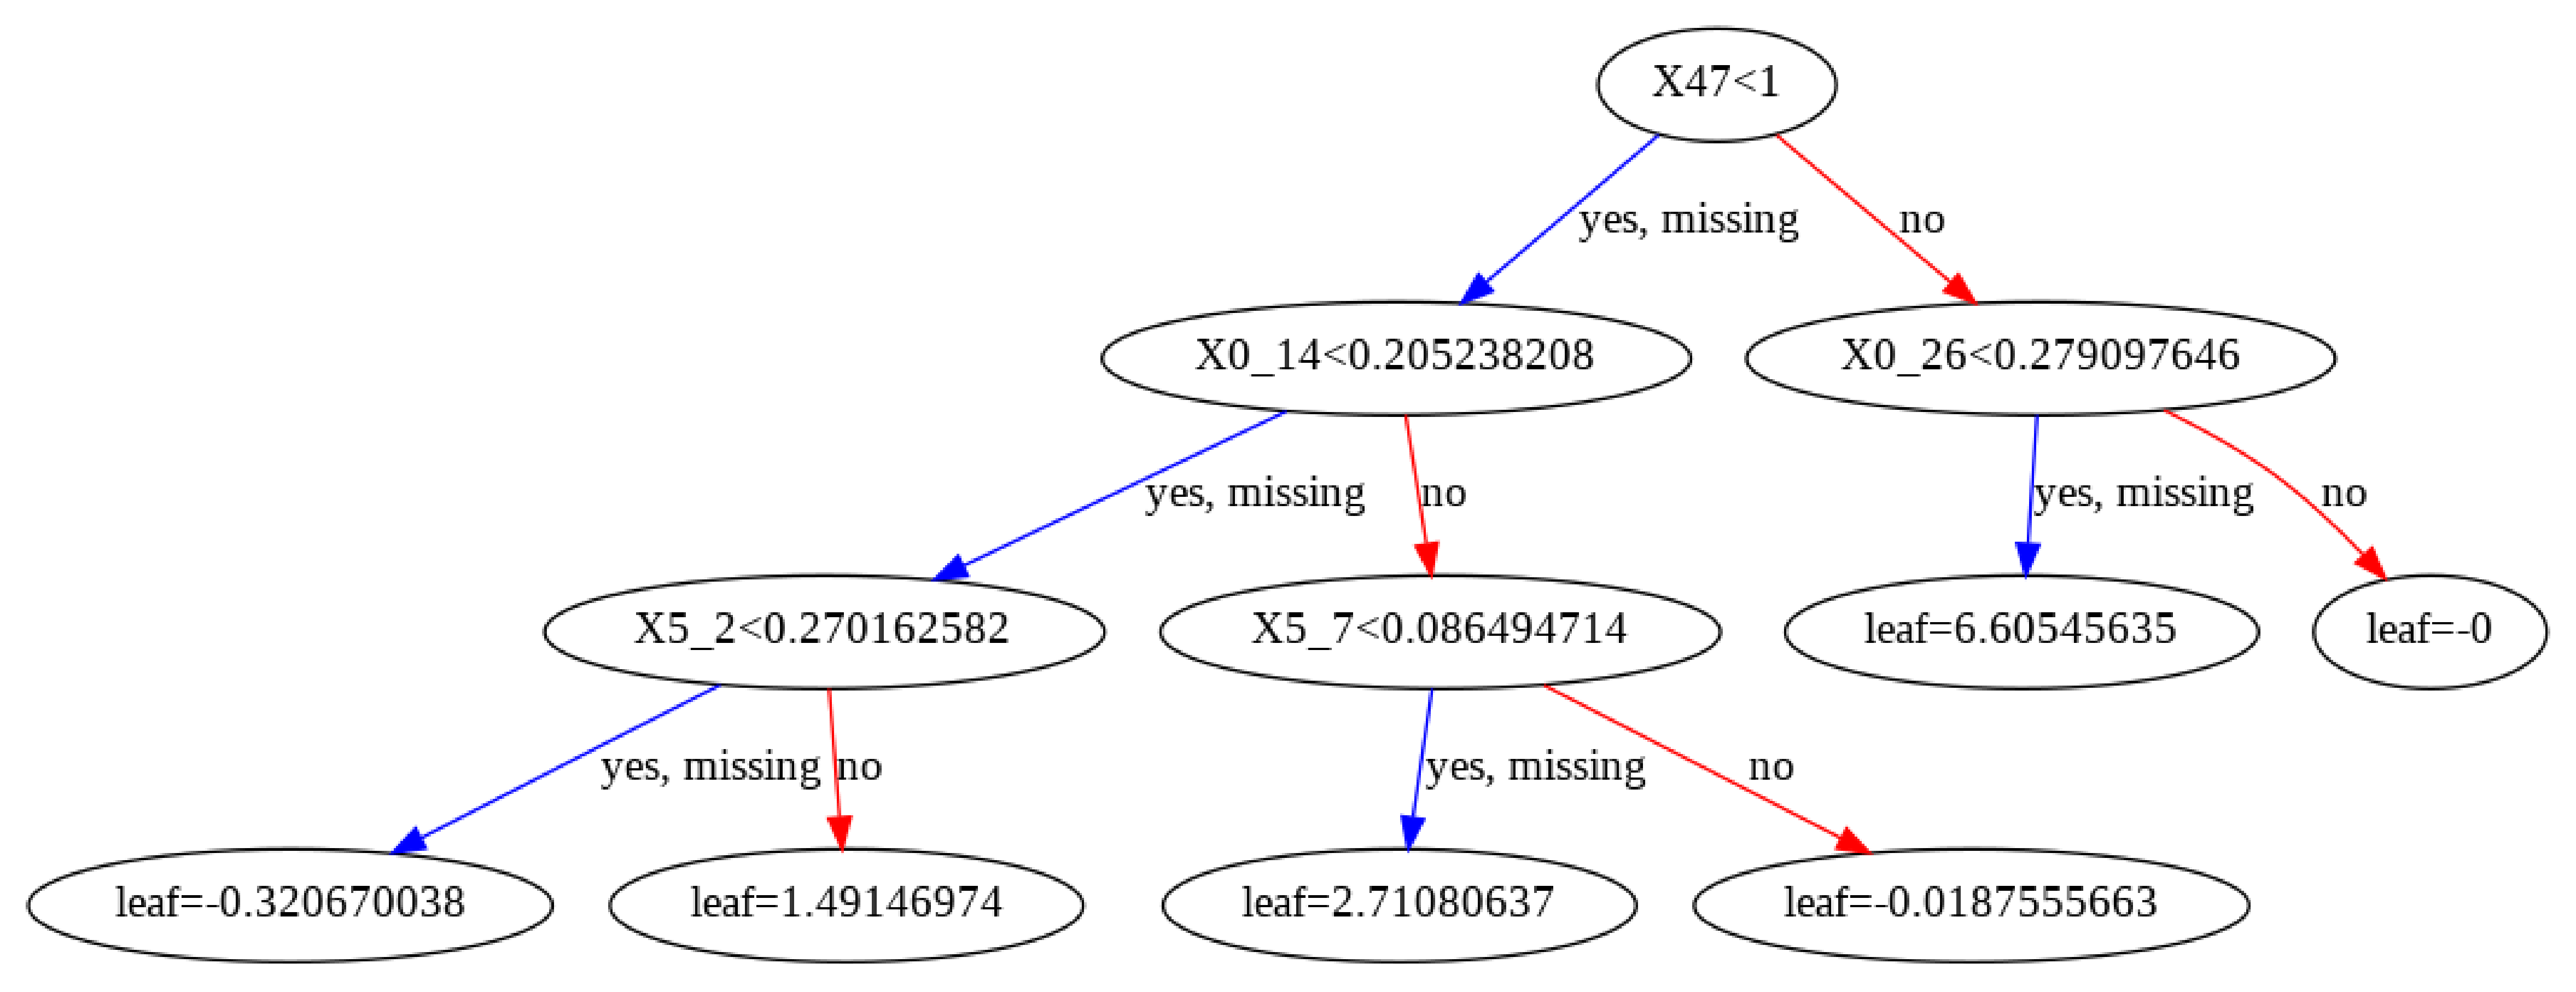

In [ ]:
from xgboost import plot_tree
fig,ax = plt.subplots(1,figsize=(20,10),dpi=300)
plot_tree(clf, ax=ax, num_trees = clf.best_iteration)

In [ ]:
y_pred = clf.predict(d_test, ntree_limit=clf.best_ntree_limit)
output = pd.DataFrame({'id': df['test']['ID'], 'y': y_pred})
output.to_csv('xgboost_test1.csv', index=False)

In [ ]:
output

,id,y
0,1,81.337524
1,2,94.278984
2,3,82.393555
3,4,80.162880
4,5,109.643509
...,...,...
4204,8410,101.698288
4205,8411,91.387177
4206,8413,90.948051
4207,8414,106.917435


In [ ]:
clfscores = pd.DataFrame.from_dict(clf.get_fscore().items())

In [ ]:
best = clfscores.sort_values(ascending=False,by=1).iloc[:5][0].to_list()

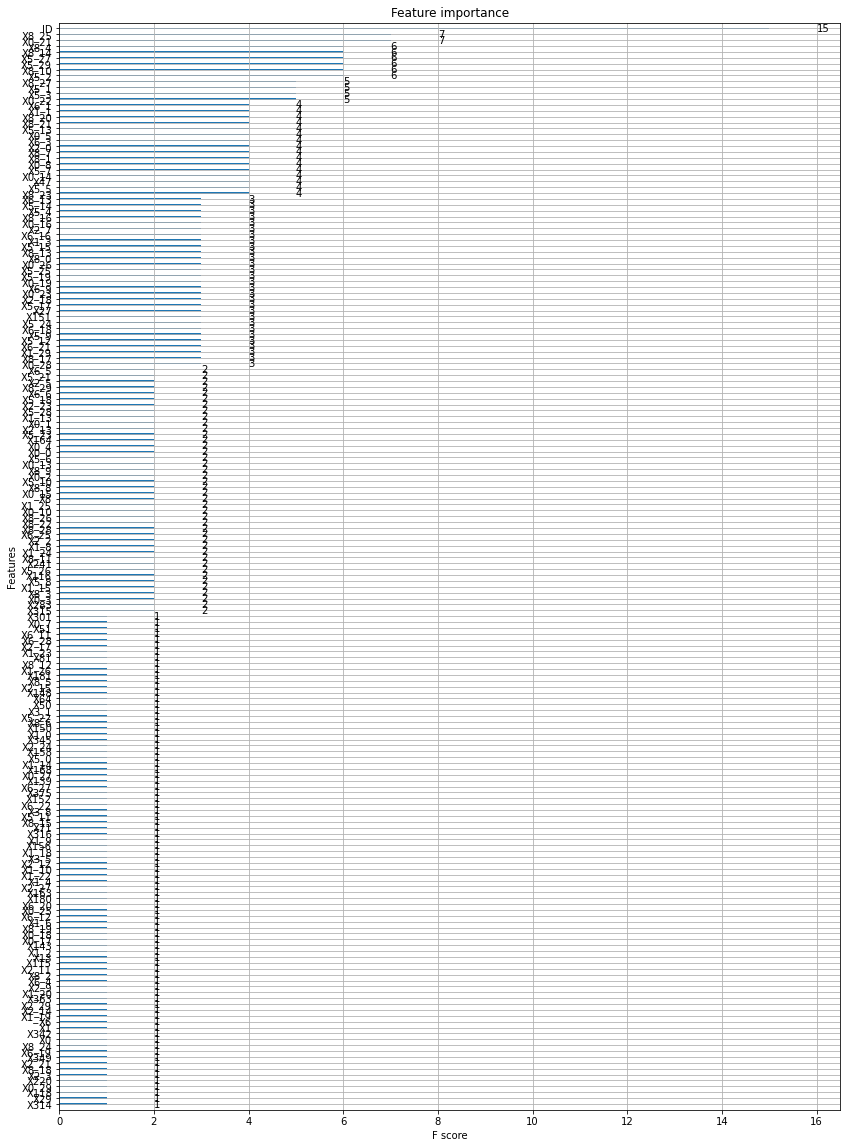

In [ ]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (14, 20)
plot_importance(clf)
plt.show()

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(trainframe, df['train']['y'], test_size=0.1, random_state=4242)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(testframe)

params = {}
params['objective'] = 'reg:squarederror'
params['eta'] = 0.14 #0.1
params['max_depth'] = 18 #18
params['booster'] = 'dart'
params['lambda'] = 120
params['alpha'] = 131
params['gamma'] = 95 #80
params['subsample'] = 0.7
params['colsample_bytree'] = 0.7


def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.cv(params, d_train, num_boost_round=999, nfold=4, feval=xgb_r2_score, early_stopping_rounds=50, maximize=True, verbose_eval=10,  )

[0]	train-r2:-52.5329+0.672936	train-rmse:87.6165+0.111725	test-r2:-52.6645+2.04638	test-rmse:87.6157+0.434509
[10]	train-r2:-3.00898+0.0475292	train-rmse:23.9771+0.0708561	test-r2:-3.01341+0.0251553	test-rmse:23.9753+0.569127
[20]	train-r2:0.306345+0.0097626	train-rmse:9.97381+0.0926828	test-r2:0.305069+0.057495	test-rmse:9.97661+0.633913
[30]	train-r2:0.593995+0.0100409	train-rmse:7.63066+0.137863	test-r2:0.580147+0.0420043	test-rmse:7.75214+0.550659
[40]	train-r2:0.636653+0.00940638	train-rmse:7.21872+0.138732	test-r2:0.608554+0.0392609	test-rmse:7.48511+0.52987


In [ ]:
clf['test-r2-mean']

In [ ]:
min_r2 = 0
num_boost_round = 999
best_params = None

# params['eta'] = 0.004 #0.09
# params['max_depth'] = 5 #18
params['booster'] = 'dart'
params['lambda'] = 66 #120
params['alpha'] = 0 #133
# params['gamma'] =  89#95
params['subsample'] = 0.9 #0.9
params['colsample_bytree'] = 0.9 #0.9
# params['min_child_weight'] = 15

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

gridsearch_params = [
    (eta, gamma, max_depth, min_child_weight)
    for eta in [0.005,0.01,0.05,0.1]
    for gamma in [10,20,30,50,70,90]
    for max_depth in range(5,20)
    for min_child_weight in [5,10,20,35]
                    ]

for eta, gamma, max_depth, min_child_weight in gridsearch_params:
    print("CV with eta={}, gamma={}, max_depth={}, min_child_weight{}".format(
                             eta,
                             gamma,
                             max_depth,
                             min_child_weight))
    
    # Update our parameters
    params['eta'] = eta
    params['gamma'] = gamma
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        d_train,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=4,
        feval=xgb_r2_score,
        early_stopping_rounds=50)
    
    # Update best MAE
    mean_r2 = cv_results['test-r2-mean'].max()
    boost_rounds = cv_results['test-r2-mean'].argmax()
    print("Mean r2: {} for {} rounds".format(mean_r2, boost_rounds))
    if mean_r2 > min_r2:
        min_r2 = mean_r2
        best_params = (eta,gamma,max_depth,min_child_weight)
print("Best params: {}, {}, {}, {}, r2: {}".format(best_params[0], best_params[1],best_params[2],best_params[3], min_r2))

In [ ]:
from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import f1_score

clf_xgb = XGBClassifier(objective = 'binary:logistic')
param_dist = {
              'max_depth': stats.randint(15, 50),
              'eta': stats.uniform(0.01, 0.2),
              'lambda': stats.uniform(120, 170),
              'alpha': stats.uniform(90, 140),
              'gamma': stats.uniform(70, 110),
             }

params = {}
params['objective'] = 'reg:squarederror'
params['eta'] = 0.1
params['max_depth'] = 18
params['booster'] = 'dart'
params['lambda'] = 140
params['alpha'] = 120
params['gamma'] = 80
params['subsample'] = 0.7
params['colsample_bytree'] = 0.7

clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 25, 
                         scoring = 'f1', error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

estimators = []
results = np.zeros(len(X))
score = 0.0

x_train, x_valid, y_train, y_valid = train_test_split(trainframe, df['train']['y'], test_size=0.1, random_state=4242)

for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    clf.fit(X_train, y_train)

    estimators.append(clf.best_estimator_)
    results[test_index] = clf.predict(X_test)
    score += f1_score(y_test, results[test_index])
score /= numFolds

In [ ]:
acc507 = pd.read_csv('xgboost_test1 (10).csv')
acc522 = pd.read_csv('xgboost_test1 (48).csv')
acc551 = pd.read_csv('xgboost_test1 (85).csv')

In [ ]:
accuracies = pd.concat([acc507['y'].rename('acc507'),acc522['y'].rename('acc522'),acc551['y'].rename('acc551')], axis=1)
acc = accuracies.T.reset_index()
acc = pd.melt(acc, id_vars=['index'], value_vars=acc.iloc[:,1:])

In [ ]:
sns.set_style(style='white')
plt.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots(1,3,figsize=(14,10))
fig = sns.scatterplot(data=acc507,x='id',y='y', color='red',ax=ax[0], alpha=0.9, s=15, edgecolor='black', linewidth=0.1)
fig = sns.scatterplot(data=acc522,x='id',y='y', color='green',ax=ax[1], alpha=0.9, s=15, edgecolor='black', linewidth=0.1)
fig = sns.scatterplot(data=acc551, x='id', y='y', color = 'blue',ax=ax[2], alpha=0.9, s=15, edgecolor='black', linewidth=0.1)
for a in ax:
  a.set_ylim(75,120)
  a.plot()

In [ ]:

# indextodrop = set()
# for x in encoded.columns:
#   if len(encoded[x].unique()) < len(test2encode[x].unique()):
#     for y in test2encode[x].unique():
#       if y not in encoded[x].unique():
#         for ind in test2encode.loc[test2encode['X0'] == 47].index:
#           indextodrop.add(ind)
# len(indextodrop)
# fornnpred = test2encode.drop(test2encode.index[list(indextodrop)])
# fornnpred.shape
# pred_input = {
#     "input_X0":fornnpred["X0"],
#     "input_X1":fornnpred["X1"],
#     "input_X2":fornnpred["X2"],
#     "input_X3":fornnpred["X3"],
#     "input_X4":fornnpred["X4"],
#     "input_X5":fornnpred["X5"],
#     "input_X6":fornnpred["X6"],
#     "input_X8":fornnpred["X8"]
# }
#nnpred = model_full.predict(pred_input)

In [ ]:
plotCluster(clusterDF(getClusters(elbow(acc['value']), 4),acc), x='variable', y='value')

In [ ]:
plt.figure(figsize=(30,30))
g = sns.FacetGrid(acc, col="index")
# g.map_dataframe(sns.scatterplot,data=acc, x='variable', y='value', hue='kpred', palette='tab10', linewidth=0.1, s=10)

In [ ]:
acc['variable'] = acc['variable'].astype('int')

In [ ]:
plt.figure(figsize=(80,30))
g = sns.FacetGrid(acc, row="index", col="kpred", hue="kpred", palette="tab10")
# g.map_dataframe(sns.regplot,data=acc, x='variable', y='value')

In [ ]:
k = {}
for x in range(0,4):
  k[x] = {}
  for y in acc['index'].unique():
    k[x][y] = {}
    k[x][y]['min'] = acc.loc[acc['kpred']==x].groupby('index').get_group(y)['value'].min()
    k[x][y]['max'] = acc.loc[acc['kpred']==x].groupby('index').get_group(y)['value'].max()
    k[x][y]['mean'] = acc.loc[acc['kpred']==x].groupby('index').get_group(y)['value'].mean()
    k[x][y]['std'] = acc.loc[acc['kpred']==x].groupby('index').get_group(y)['value'].std()
    k[x][y]['var'] = acc.loc[acc['kpred']==x].groupby('index').get_group(y)['value'].var()

level1 = []
level2 = []
for x in k.keys():
  level1.append(x)
  level1.append(x)
  level1.append(x)
  for y in k[x].keys():
    level2.append(y)

indexML = pd.MultiIndex.from_arrays(arrays=[level1,level2],names=['K-Value','Model'])
srs = pd.DataFrame(k).stack()
stackdf = pd.DataFrame(srs.tolist(), index=indexML).swaplevel().to_dict()
stackdf = pd.DataFrame.from_dict(stackdf)

In [ ]:
aaa = pd.concat([encoded, df['train'].drop(['y','X0','X1','X2','X3','X4','X5','X6','X8','kpred'],axis=1)],axis=1)

In [ ]:
bbb = pd.concat([test2encode, df['test'].drop(['X0','X1','X2','X3','X4','X5','X6','X8'],axis=1)],axis=1)

In [ ]:
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(aaa, df['train']['y'], test_size=0.2, random_state=None)

d_train2 = xgb.DMatrix(x_train2, label=y_train2)
d_valid2 = xgb.DMatrix(x_valid2, label=y_valid2)
d_test2 = xgb.DMatrix(bbb)

params = {}
params['objective'] = 'reg:squarederror'
params['eta'] = 0.01 #0.09
params['max_depth'] = 4 #18
params['booster'] = 'dart'
params['lambda'] = 19 #120
params['alpha'] = 20 #133
params['gamma'] =  17#95
params['subsample'] = 0.9 #0.9
params['colsample_bytree'] = 0.9 #0.9
params['min_child_weight'] = 5
params['sample_type'] = 'uniform'
params['normalize_type'] = 'tree'
params['rate_drop'] = 0.9
params['skip_drop'] = 0.5


def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train2, 'train'), (d_valid2, 'valid')]

clf2 = xgb.train(params, d_train2, 5000, watchlist, early_stopping_rounds=150, feval=xgb_r2_score, maximize=True, verbose_eval=10)

[0]	train-rmse:99.602	valid-rmse:99.9548	train-r2:-69.4788	valid-r2:-64.2715
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 150 rounds.
[10]	train-rmse:99.6348	valid-rmse:91.855	train-r2:-70.8789	valid-r2:-53.0524
[20]	train-rmse:99.5318	valid-rmse:99.9431	train-r2:-69.5609	valid-r2:-64.2715
[30]	train-rmse:84.7675	valid-rmse:99.0224	train-r2:-69.3275	valid-r2:-45.4597
[40]	train-rmse:98.678	valid-rmse:99.0391	train-r2:-46.9281	valid-r2:-62.4107
[50]	train-rmse:78.1187	valid-rmse:78.5398	train-r2:-69.9206	valid-r2:-38.5174
[60]	train-rmse:96.8471	valid-rmse:99.9642	train-r2:-38.9912	valid-r2:-63.0554
[70]	train-rmse:99.0649	valid-rmse:70.4929	train-r2:-33.8446	valid-r2:-58.9093
[80]	train-rmse:98.0881	valid-rmse:97.6452	train-r2:-31.1728	valid-r2:-62.2867
[90]	train-rmse:65.2984	valid-rmse:65.7814	train-r2:-29.292	valid-r2:-26.7215
[100]	train-rmse:94.8316	valid-rmse:62.0674	train-r2:-25.9294	valid-r2:-2

In [ ]:
y_pred2 = clf2.predict(d_test2, ntree_limit=clf2.best_ntree_limit)
output2 = pd.DataFrame({'id': df['test']['ID'], 'y': y_pred2})
output2.to_csv('xgboost_test2.csv', index=False)

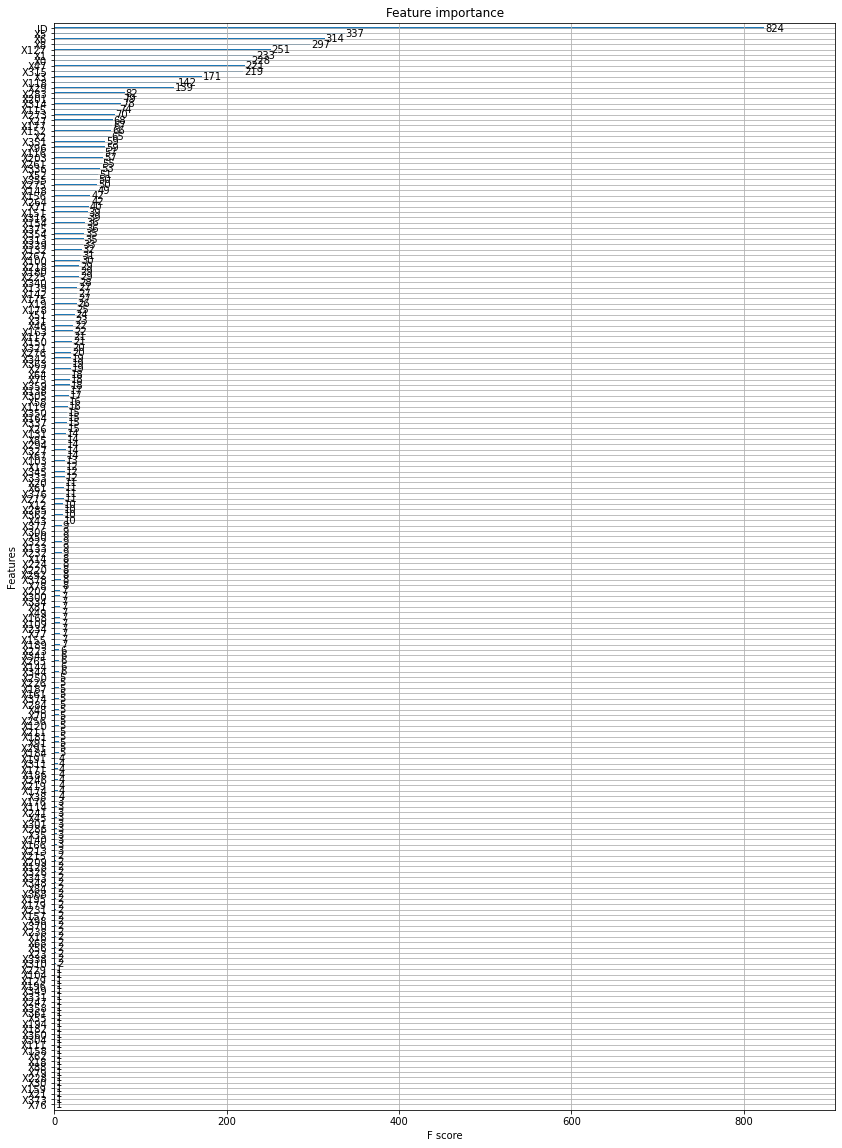

In [ ]:
plt.rcParams["figure.figsize"] = (14, 20)
plot_importance(clf2)
plt.show()

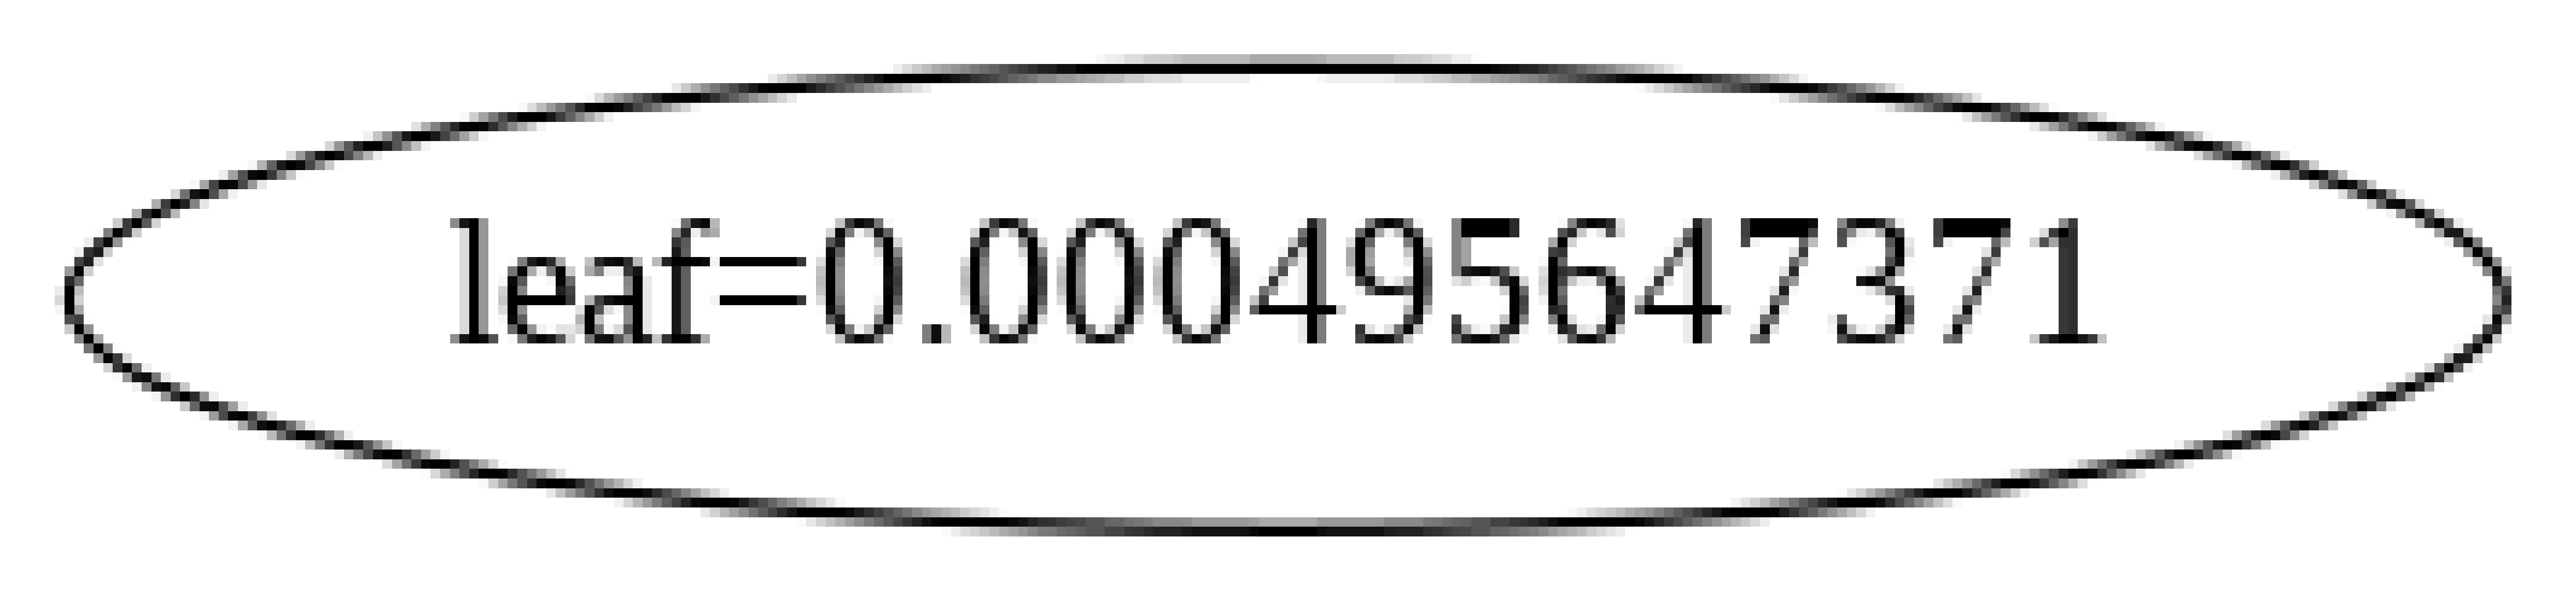

In [ ]:
from xgboost import plot_tree
fig,ax = plt.subplots(1,figsize=(20,10),dpi=300)
plot_tree(clf2, ax=ax, num_trees = clf2.best_iteration)